# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [201]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [202]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [14]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [15]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

{
    "a": jnp.array([1.0, 2.0, 3.0], dtype=jnp.float32),
    "b": jnp.array(2.0, dtype=jnp.float32),
    "c": {"d": jnp.array(3.0, dtype=jnp.float32)},
}

flat_array, pytree_def = jax.tree_util.tree_flatten(initial_params)

design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 1e-2,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 360
Number of faces: 708
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

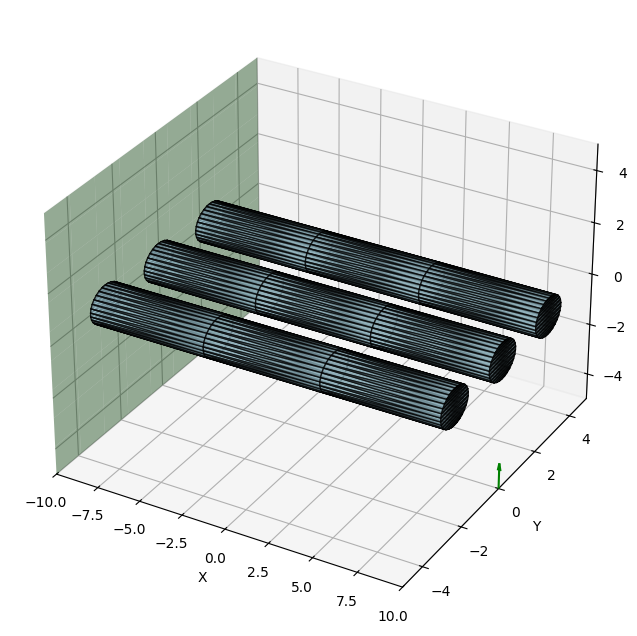

In [16]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

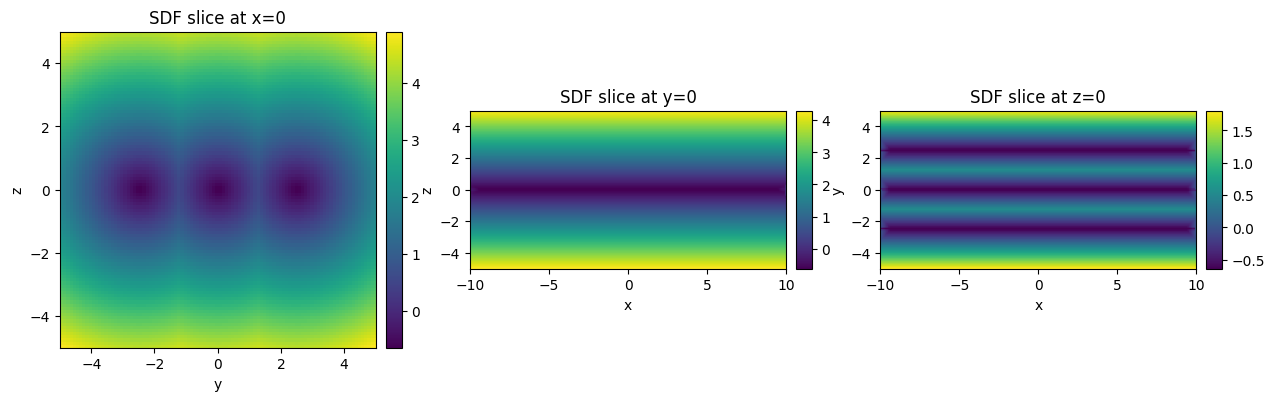

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [18]:
primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            **design_inputs,
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (3, 4, 3)


And figure out an approate epsilon for finite difference based Jacobian computation.

In [209]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, 0, 6)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     primal, vjp_fun = jax.vjp(
#         lambda params, eps=eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 "non_differentiable_parameters": jnp.array(
#                     [bar_radius], dtype=jnp.float32
#                 ),
#                 "static_parameters": [n_chains, n_edges_per_chain + 1],
#                 "string_parameters": [],
#                 "mesh_tesseract": TesseractReference(bar_3d_tess),
#                 "grid_size": [Lx, Ly, Lz],
#                 "grid_elements": [Nx, Ny, Nz],
#                 "grid_center": [0.0, 0.0, 0.0],
#                 "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
#                 "normalize_jacobian": True,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [210]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 6.239625508897007e-05, rho max: 0.7989268898963928


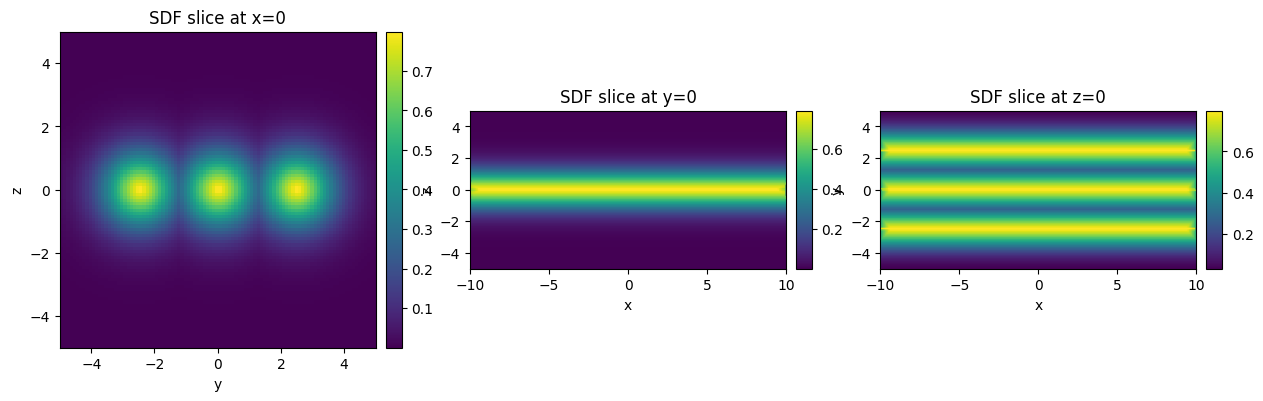

In [19]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.499988079071045


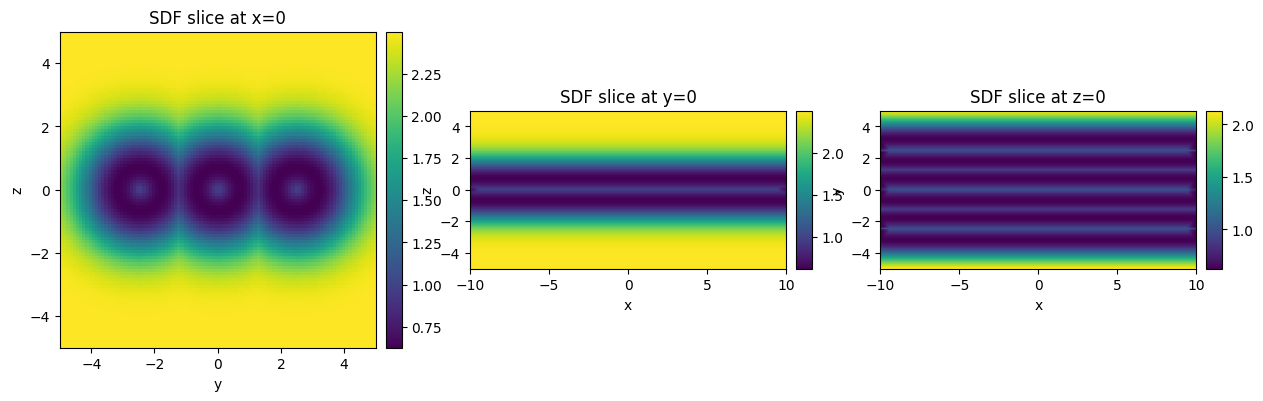

In [20]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing = sizing_field(sdf, min_size=Lx / 32, max_size=Lx / 8, scale=1.0)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [21]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 5,
        "max_points": 7000,
        "max_cells": 7000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 5201, Mesh faces: 4160


Lets check the gradient of the meshing Tesseract

In [116]:
# max_points = 5000
# max_cells = 5000

# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
#             "field_values": rho,
#             "max_subdivision_levels": 4,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [117]:
# # Lets export it to a .vtk using pyvista
# import pyvista as pv


# def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
#     """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

#     Args:
#         pts: Array of point coordinates, shape (N, 3).
#         faces: Array of hexahedral cell connectivity, shape (M, 8).

#     Returns:
#         PyVista mesh representing the hexahedral grid.
#     """
#     # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
#     cell_type = pv.CellType.HEXAHEDRON
#     cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

#     # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
#     n_cells = faces.shape[0]
#     cells = np.empty((n_cells, 9), dtype=np.int64)
#     cells[:, 0] = 8  # Each cell has 8 points
#     cells[:, 1:9] = faces

#     # Flatten the cells array for PyVista
#     cells = cells.flatten()

#     return pv.UnstructuredGrid(cells, cell_types, pts)


# # convert arrays to numpy
# pts_np = np.array(adaptive_mesh["points"])
# cells_np = np.array(adaptive_mesh["faces"])

# hex_mesh = hex_to_pyvista(pts_np, cells_np)

# print(hex_mesh)

# hex_mesh.save("fem_shapeopt_mesh.vtk")

## Boundary Conditions

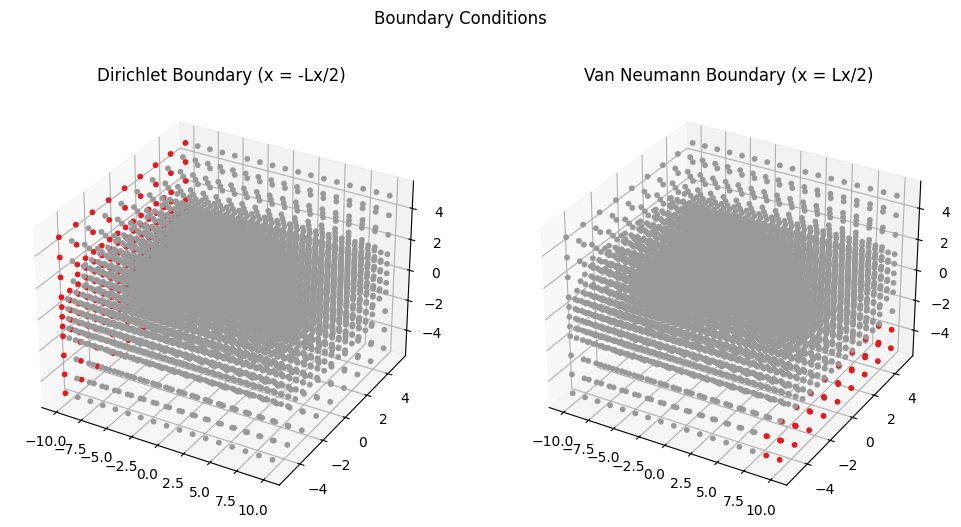

In [22]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 6),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 6),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [ ]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [ ]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-08 12:20:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:20:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:20:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-08 12:20:46][DEBUG] jax_fem: Done pre-computations, took 1.4597411155700684 [s]
[11-08 12:20:46][INFO] jax_fem: Solving a problem with 4160 cells, 5201x3 = 15603 dofs.
[11-08 12:20:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:20:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:20:48][DEBUG] jax_fem: Start timing
[11-08 12:20:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:20:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.2838 seconds
[11-08 12:20:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:20:49][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res = 1.0
[11-08 12:20:49][DEBUG] jax_fem: Solving linear system...
[11-08 12:20:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-08 12:20:57][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 3.264575616719758e-09
[11-08 12:20:57][DEBUG] j

Compliance: 27264.8809


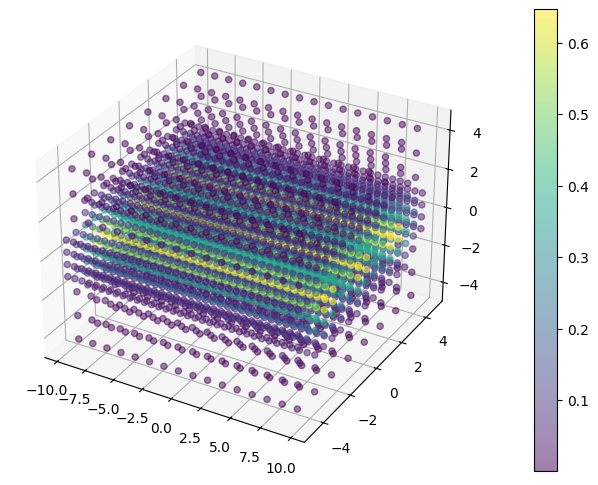

In [218]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [219]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    cell_values: jnp.ndarray,
    mesh: dict,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        cell_values: Material density values for each mesh cell.
        mesh: Mesh dictionary.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    mesh = stop_grads_int(mesh)

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": cell_values,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [220]:
# get the gradient of the loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(
    jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
)
print("Grad shape:", grad.shape)

[11-08 12:21:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:21:08][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:21:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-08 12:21:09][DEBUG] jax_fem: Done pre-computations, took 0.6961874961853027 [s]
[11-08 12:21:09][INFO] jax_fem: Solving a problem with 4160 cells, 5201x3 = 15603 dofs.
[11-08 12:21:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:21:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:21:09][DEBUG] jax_fem: Start timing
[11-08 12:21:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:21:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.2093 seconds
[11-08 12:21:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:21:09][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res = 1.0
[11-08 12:21:09][DEBUG] jax_fem: Solving linear system...
[11-08 12:21:09][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-08 12:21:16][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 3.264575616719758e-09
[11-08 12:21:16][DEBUG] j

Grad shape: (7000, 1)


Voxel center points shape: (4160, 3)
4160


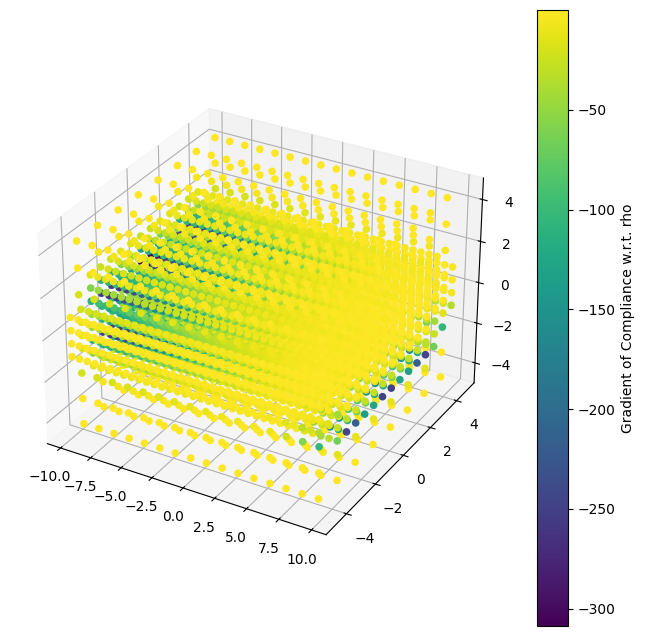

In [221]:
# print a 3D point cloud of the gradient field
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
voxel_center_points = jnp.mean(pts_coords[hex_cells], axis=1)
print("Voxel center points shape:", voxel_center_points.shape)
print(mesher_out["mesh"]["n_faces"])
sc = ax.scatter(
    voxel_center_points[:, 0],
    voxel_center_points[:, 1],
    voxel_center_points[:, 2],
    c=grad[: mesher_out["mesh"]["n_faces"], 0],
    cmap="viridis",
    alpha=1.0,
)
# lets add a colorbar
plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [222]:
max_points = 9000
max_cells = 9000


def loss(
    rho: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        rho: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sizing = sizing_field(sdf, min_size=Lx / 32, max_size=Lx / 8, scale=1.0)

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [223]:
# get grads of loss w.r.t. rho
grad_loss = jax.grad(loss)
print(rho.shape)
grad = grad_loss(rho)

(200, 100, 100)


[11-08 12:21:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:21:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:21:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:21:42][DEBUG] jax_fem: Done pre-computations, took 0.7540175914764404 [s]
[11-08 12:21:42][INFO] jax_fem: Solving a problem with 4160 cells, 5201x3 = 15603 dofs.
[11-08 12:21:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:21:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:21:42][DEBUG] jax_fem: Start timing
[11-08 12:21:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:21:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.2220 seconds
[11-08 12:21:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:21:43][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

Grad min: -308.64954 Grad max: -8.065023e-06


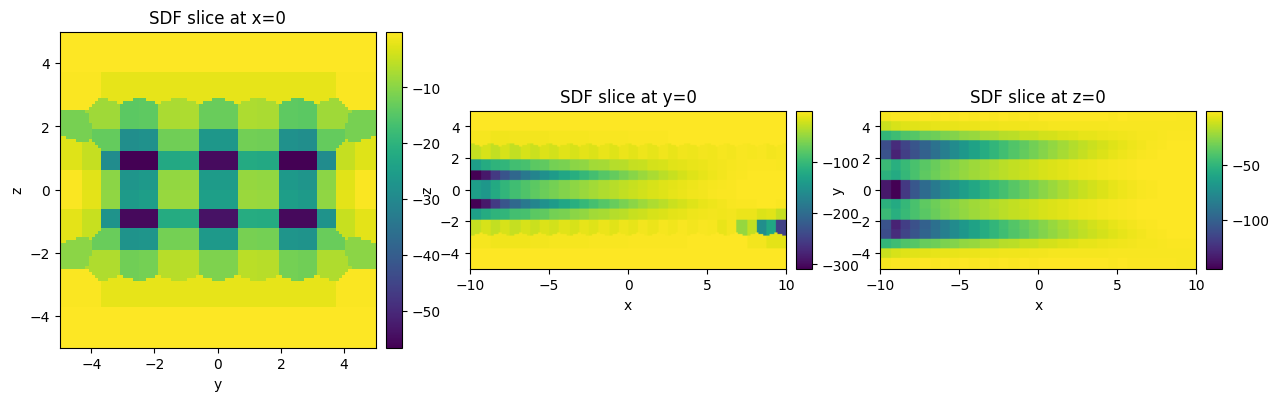

In [224]:
# plot the grad field
plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)
print("Grad min:", jnp.min(grad), "Grad max:", jnp.max(grad))

In [225]:
max_points = 9000
max_cells = 9000


def loss(
    params: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "grid_center": [0.0, 0.0, 0.0],
            "epsilon": 1e-2,  # epsilon, only used for FD of the jacobian
            "normalize_jacobian": True,
        },
    )["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(sdf, min_size=Lx / 32, max_size=Lx / 8, scale=1.0)
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [227]:
import optax

n_steps = 40
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.1, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss)

for i in range(n_steps):
    loss_value, grads = grad_fn(params)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[11-08 12:36:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:36:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:36:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:36:27][DEBUG] jax_fem: Done pre-computations, took 1.554999828338623 [s]
[11-08 12:36:27][INFO] jax_fem: Solving a problem with 4160 cells, 5201x3 = 15603 dofs.
[11-08 12:36:27][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:36:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:36:29][DEBUG] jax_fem: Start timing
[11-08 12:36:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:36:29][DEBUG] jax_fem: Function split_and_compute_cell took 0.2935 seconds
[11-08 12:36:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:36:30][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[ 0.01899523  0.00196882 -0.0089694 ]
  [ 0.01164134  0.02515115  0.00290267]
  [-0.02124063  0.0256153  -0.00640046]
  [ 0.00700069  0.0124695   0.05051221]]

 [[ 0.07890753 -0.00422941 -0.03070007]
  [ 0.01189242  0.01156801 -0.00089641]
  [ 0.00400817  0.01009749  0.00434989]
  [ 0.01410518 -0.02055056  0.0237901 ]]

 [[ 0.06170753  0.01239049  0.00150104]
  [-0.02841221 -0.00400391 -0.01013712]
  [-0.00622546  0.00723882  0.00670222]
  [ 0.01712167 -0.02102223  0.03451986]]]
[[[-10.         -2.5         0.       ]
  [ -3.3333333  -2.5         0.       ]
  [  3.3333333  -2.5         0.       ]
  [ 10.         -2.5         0.       ]]

 [[-10.          0.          0.       ]
  [ -3.3333333   0.          0.       ]
  [  3.3333333   0.          0.       ]
  [ 10.          0.          0.       ]]

 [[-10.          2.5         0.       ]
  [ -3.3333333   2.5         0.       ]
  [  3.3333333   2.5         0.       ]
  [ 10.          2.5         0.       ]]]
Iteration 1, Loss: 27264.88


[11-08 12:37:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:37:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:37:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:37:18][DEBUG] jax_fem: Done pre-computations, took 0.7009620666503906 [s]
[11-08 12:37:18][INFO] jax_fem: Solving a problem with 4160 cells, 5201x3 = 15603 dofs.
[11-08 12:37:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:37:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:37:18][DEBUG] jax_fem: Start timing
[11-08 12:37:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:37:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.2177 seconds
[11-08 12:37:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:37:19][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.04017434  0.01038555  0.02745632]
  [-0.00155285  0.0233067   0.02943626]
  [ 0.00039035  0.01562764  0.00267481]
  [ 0.00306202  0.01239819  0.03616833]]

 [[ 0.05114243  0.00909514 -0.0636365 ]
  [-0.00093578  0.00870469 -0.05789008]
  [-0.00091619  0.00089945  0.00181935]
  [ 0.00275201  0.00050949  0.03281608]]

 [[ 0.01749633 -0.01354546  0.02892786]
  [ 0.00136672 -0.00911396  0.0149522 ]
  [ 0.00120515 -0.01834559  0.001857  ]
  [-0.00317813 -0.01285999  0.03756133]]]
[[[-10.          -2.5999994    0.09999989]
  [ -3.3333333   -2.6         -0.09999966]
  [  3.3333333   -2.6          0.09999985]
  [ 10.          -2.6         -0.09999998]]

 [[-10.           0.09999977   0.09999998]
  [ -3.3333333   -0.09999992   0.09999888]
  [  3.3333333   -0.0999999   -0.09999978]
  [ 10.           0.09999996  -0.09999996]]

 [[-10.           2.4         -0.09999933]
  [ -3.3333333    2.5999997    0.0999999 ]
  [  3.3333333    2.4         -0.09999986]
  [ 10.           2.6         -0.0999

[11-08 12:38:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:38:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:38:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:38:02][DEBUG] jax_fem: Done pre-computations, took 1.2866437435150146 [s]
[11-08 12:38:02][INFO] jax_fem: Solving a problem with 4237 cells, 5290x3 = 15870 dofs.
[11-08 12:38:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:38:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:38:04][DEBUG] jax_fem: Start timing
[11-08 12:38:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:38:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.5290 seconds
[11-08 12:38:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:38:05][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 5.0624557e-02  1.2588941e-02  6.8030179e-02]
  [-2.7068462e-03  5.9231729e-03  7.1793966e-02]
  [ 7.3624548e-04  5.9944489e-03  5.5818371e-03]
  [ 4.3309419e-03  7.8550614e-03  4.6492293e-02]]

 [[ 3.5045587e-02  1.0425949e-02 -1.4694609e-01]
  [-4.0454254e-03 -5.3414786e-03 -1.4356166e-01]
  [-7.5165438e-04 -4.4514981e-04 -8.0125900e-03]
  [ 4.5546432e-05  1.6912824e-03  4.6377737e-02]]

 [[ 7.4982853e-03 -9.5857540e-03  7.4533030e-02]
  [ 6.1230623e-04 -6.5251170e-03  6.8083644e-02]
  [ 7.8837347e-04 -6.9759898e-03  1.1566899e-02]
  [-2.9674967e-04 -8.1535028e-03  5.1658574e-02]]]
[[[-10.          -2.6853611    0.05019076]
  [ -3.3333333   -2.699467    -0.18041462]
  [  3.3333333   -2.6957104    0.13302684]
  [ 10.          -2.6997213   -0.19754961]]

 [[-10.           0.06086399   0.1958782 ]
  [ -3.3333333   -0.19802925   0.17524211]
  [  3.3333333   -0.17315383  -0.19029894]
  [ 10.           0.16496855  -0.1993115 ]]

 [[-10.           2.409681    -0.17757897]
  [ -3.3333333 

[11-08 12:39:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:39:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:39:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:39:01][DEBUG] jax_fem: Done pre-computations, took 1.5696663856506348 [s]
[11-08 12:39:01][INFO] jax_fem: Solving a problem with 4307 cells, 5360x3 = 16080 dofs.
[11-08 12:39:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:39:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:39:03][DEBUG] jax_fem: Start timing
[11-08 12:39:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:39:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.5659 seconds
[11-08 12:39:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:39:05][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.05114789  0.01350253  0.10281861]
  [-0.0030652  -0.00371226  0.10993325]
  [ 0.00080191  0.00867939  0.02040817]
  [ 0.00449808  0.00814715  0.05855457]]

 [[ 0.0465537  -0.00334076 -0.22970234]
  [-0.00637562 -0.00340137 -0.23017323]
  [-0.00139338 -0.00468162 -0.03025203]
  [ 0.00460197  0.0020474   0.05736996]]

 [[ 0.01044198 -0.00033944  0.12607533]
  [ 0.00030434  0.00374517  0.11897764]
  [ 0.00138242 -0.00393916  0.03147897]
  [ 0.00075503 -0.00817031  0.06345124]]]
[[[-1.0000000e+01 -2.7763433e+00 -2.3306817e-02]
  [-3.3333333e+00 -2.7858570e+00 -2.6278022e-01]
  [ 3.3333333e+00 -2.7805274e+00  1.1299806e-01]
  [ 1.0000000e+01 -2.7958436e+00 -2.9583949e-01]]

 [[-1.0000000e+01 -5.8550984e-03  2.8517026e-01]
  [-3.3333333e+00 -2.4691561e-01  2.5586748e-01]
  [ 3.3333333e+00 -2.2670838e-01 -1.7080219e-01]
  [ 1.0000000e+01  2.0967264e-01 -2.9753909e-01]]

 [[-1.0000000e+01  2.4457259e+00 -2.5846982e-01]
  [-3.3333333e+00  2.7908051e+00  9.8928809e-03]
  [ 3.3333333e+00  2

[11-08 12:39:51][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:39:51][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:39:51][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:39:53][DEBUG] jax_fem: Done pre-computations, took 1.5143160820007324 [s]
[11-08 12:39:53][INFO] jax_fem: Solving a problem with 4237 cells, 5305x3 = 15915 dofs.
[11-08 12:39:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:39:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:39:53][DEBUG] jax_fem: Start timing
[11-08 12:39:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:39:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.3546 seconds
[11-08 12:39:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:39:54][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 4.4337634e-02  6.3233525e-03  1.3611753e-01]
  [-3.7382091e-03 -6.8176044e-03  1.5443964e-01]
  [ 1.4335224e-03 -6.3586846e-04  3.0766610e-02]
  [ 3.9461427e-03  7.0146117e-03  7.1779296e-02]]

 [[ 6.6075973e-02  5.7230322e-03 -2.7618754e-01]
  [-8.2588429e-03 -4.3206420e-03 -2.8410736e-01]
  [-3.4225364e-03 -2.2331434e-03 -5.0323967e-02]
  [ 5.7112090e-03  2.3382108e-03  6.2023725e-02]]

 [[ 8.0970144e-03 -9.9208835e-04  1.4919837e-01]
  [-2.2547762e-04  8.6412132e-03  1.4059347e-01]
  [ 1.5003167e-03  4.5208714e-04  3.4453165e-02]
  [ 2.7359182e-03 -8.8130068e-03  6.8823136e-02]]]
[[[-10.          -2.870376    -0.10516566]
  [ -3.3333333   -2.8499134   -0.3486892 ]
  [  3.3333333   -2.8629375    0.05360659]
  [ 10.          -2.8906407   -0.3946661 ]]

 [[-10.          -0.04598214   0.3744035 ]
  [ -3.3333333   -0.27349147   0.34046328]
  [  3.3333333   -0.24224328  -0.11101106]
  [ 10.           0.24031264  -0.39555374]]

 [[-10.           2.476116    -0.342548  ]
  [ -3.3333333 

[11-08 12:40:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:40:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:40:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:40:34][DEBUG] jax_fem: Done pre-computations, took 1.4815270900726318 [s]
[11-08 12:40:34][INFO] jax_fem: Solving a problem with 4153 cells, 5224x3 = 15672 dofs.
[11-08 12:40:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:40:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:40:36][DEBUG] jax_fem: Start timing
[11-08 12:40:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:40:36][DEBUG] jax_fem: Function split_and_compute_cell took 0.5410 seconds
[11-08 12:40:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:40:37][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.03392076  0.00350314  0.16322812]
  [-0.00399422 -0.01529674  0.18192433]
  [ 0.00309062 -0.00651776  0.04196303]
  [ 0.00455538  0.00358057  0.08169352]]

 [[ 0.08392046 -0.0100188  -0.3393073 ]
  [-0.00823138 -0.00505803 -0.36186534]
  [-0.00659159  0.00330544 -0.06834441]
  [ 0.01169031  0.00390561  0.06620678]]

 [[ 0.0047429  -0.0047627   0.15861525]
  [-0.00091736  0.00932063  0.18032871]
  [ 0.00144123  0.00654629  0.03308798]
  [ 0.00505475 -0.00579607  0.07707576]]]
[[[-10.          -2.9617474   -0.19168371]
  [ -3.3333333   -2.8925745   -0.43695658]
  [  3.3333333   -2.931315    -0.01947139]
  [ 10.          -2.9835837   -0.49374616]]

 [[-10.          -0.09697458   0.46590132]
  [ -3.3333333   -0.2808408    0.42890036]
  [  3.3333333   -0.24448968  -0.03848864]
  [ 10.           0.25991645  -0.49408963]]

 [[-10.           2.504292    -0.43083414]
  [ -3.3333333    2.8573368   -0.15133189]
  [  3.3333333    2.5958607   -0.44000292]
  [ 10.           2.960109    -0.4975

[11-08 12:41:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:41:20][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:41:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:41:22][DEBUG] jax_fem: Done pre-computations, took 1.5037178993225098 [s]
[11-08 12:41:22][INFO] jax_fem: Solving a problem with 4006 cells, 5074x3 = 15222 dofs.
[11-08 12:41:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:41:23][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:41:23][DEBUG] jax_fem: Start timing
[11-08 12:41:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:41:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.5906 seconds
[11-08 12:41:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:41:26][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 2.8335985e-02 -2.0389587e-03  1.7316924e-01]
  [-5.4023322e-03 -2.2237049e-02  2.0540573e-01]
  [-5.7777429e-06 -2.0721341e-02  5.3553812e-02]
  [ 8.9091214e-04  1.8504403e-03  8.5024022e-02]]

 [[ 9.2203811e-02 -2.6666736e-03 -3.6831957e-01]
  [-9.2070037e-03  2.3096857e-04 -4.0200573e-01]
  [-6.2920139e-03  9.8996074e-04 -8.4402286e-02]
  [ 1.1472437e-02  6.2506865e-03  6.8207815e-02]]

 [[ 3.0354948e-03 -2.9223242e-03  1.7783043e-01]
  [-3.5717277e-04  3.4507286e-02  1.8686551e-01]
  [ 1.5476600e-03  1.3234345e-02  4.6161100e-02]
  [ 9.3930960e-03 -3.1242331e-03  7.7028222e-02]]]
[[[-10.          -3.0473723   -0.28156394]
  [ -3.3333333   -2.9059095   -0.5279008 ]
  [  3.3333333   -2.9785266   -0.09982472]
  [ 10.          -3.070713    -0.5931612 ]]

 [[-10.          -0.10656632   0.5591268 ]
  [ -3.3333333   -0.2716457    0.5197915 ]
  [  3.3333333   -0.26072693   0.04129941]
  [ 10.           0.26697293  -0.59321713]]

 [[-10.           2.5394526   -0.52245826]
  [ -3.3333333 

[11-08 12:42:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:42:08][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:42:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:42:09][DEBUG] jax_fem: Done pre-computations, took 1.224306344985962 [s]
[11-08 12:42:09][INFO] jax_fem: Solving a problem with 3950 cells, 5015x3 = 15045 dofs.
[11-08 12:42:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:42:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:42:11][DEBUG] jax_fem: Start timing
[11-08 12:42:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:42:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.5236 seconds
[11-08 12:42:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:42:12][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[-3.1625423e-01 -3.3890608e-01 -2.7140456e-01]
  [ 3.7857604e-01 -1.7312322e+00 -1.2666842e+01]
  [ 1.6644573e-01 -9.1089594e-01 -3.7190995e-01]
  [ 1.0571563e+00 -7.8722010e+00 -1.2691480e+00]]

 [[ 3.0916939e+00 -5.0379598e-01 -1.7101021e+01]
  [-9.8336691e-01 -1.1621790e+01 -1.8576664e+01]
  [-6.4763683e-01 -7.2307765e-01 -3.5057762e+00]
  [ 1.3241720e-01 -1.3727266e+00 -3.6094904e+00]]

 [[ 1.8811498e-02 -2.5198208e+01  3.2667446e+01]
  [ 7.3858455e-04 -5.3299556e+00  4.8724186e+01]
  [ 3.5504609e-01  8.8078845e-01  4.6640401e+00]
  [-1.2236985e+00  7.1527100e-01  4.6291095e-01]]]
[[[-10.          -3.117133    -0.3742803 ]
  [ -3.3333333   -2.8911505   -0.62117535]
  [  3.3333333   -2.9863033   -0.18491492]
  [ 10.          -3.1504662   -0.69307154]]

 [[-10.          -0.10782812   0.65419763]
  [ -3.3333333   -0.26431042   0.6130359 ]
  [  3.3333333   -0.2789748    0.1261189 ]
  [ 10.           0.25874722  -0.6928937 ]]

 [[-10.           2.5765903   -0.6164927 ]
  [ -3.3333333 

[11-08 12:43:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:43:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:43:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:43:02][DEBUG] jax_fem: Done pre-computations, took 1.2307031154632568 [s]
[11-08 12:43:02][INFO] jax_fem: Solving a problem with 3971 cells, 5039x3 = 15117 dofs.
[11-08 12:43:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:43:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:43:04][DEBUG] jax_fem: Start timing
[11-08 12:43:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:43:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.5344 seconds
[11-08 12:43:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:43:05][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 2.77106706e-02 -4.10179980e-03  1.83378711e-01]
  [-6.26405049e-03 -2.08330844e-02  2.23350510e-01]
  [ 2.03536521e-03 -3.35365497e-02  5.09741195e-02]
  [-3.80444154e-03 -1.67586852e-03  8.59473273e-02]]

 [[ 7.80801028e-02 -3.59519501e-03 -3.84880513e-01]
  [-8.12745839e-03 -2.38798633e-02 -4.24808353e-01]
  [-1.20546622e-02 -6.76075323e-03 -9.53642428e-02]
  [ 1.11145424e-02  9.77213122e-03  6.56607524e-02]]

 [[ 7.14313006e-03  6.22406695e-03  1.94947019e-01]
  [ 2.94359401e-04  4.36687805e-02  2.09810317e-01]
  [ 1.38076930e-03  2.10948270e-02  5.47731668e-02]
  [ 1.29368445e-02  8.92781478e-04  7.62769803e-02]]]
[[[-10.          -3.0726347   -0.40232652]
  [ -3.3333333   -2.8421626   -0.57473713]
  [  3.3333333   -2.9379652   -0.15260504]
  [ 10.          -3.101996    -0.65639234]]

 [[-10.          -0.05923451   0.705944  ]
  [ -3.3333333   -0.21563126   0.66463   ]
  [  3.3333333   -0.23057503   0.17738804]
  [ 10.           0.3072945   -0.6476844 ]]

 [[-10.           2.62

[11-08 12:43:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:43:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:43:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:43:48][DEBUG] jax_fem: Done pre-computations, took 1.2221417427062988 [s]
[11-08 12:43:48][INFO] jax_fem: Solving a problem with 3999 cells, 5070x3 = 15210 dofs.
[11-08 12:43:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:43:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:43:49][DEBUG] jax_fem: Start timing
[11-08 12:43:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:43:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.5491 seconds
[11-08 12:43:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:43:51][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.03405271 -0.00361089  0.18705574]
  [-0.00547892 -0.02195137  0.21388084]
  [ 0.00400987 -0.02680584  0.05640073]
  [ 0.00096036 -0.00393811  0.08950314]]

 [[ 0.08826303 -0.00118288 -0.38273498]
  [-0.01007776 -0.01040335 -0.4220902 ]
  [-0.01198848 -0.01015246 -0.09465475]
  [ 0.01773302  0.00976538  0.06113528]]

 [[ 0.0084476   0.00454003  0.19228113]
  [ 0.0005708   0.04296708  0.21574546]
  [ 0.00173168  0.02120327  0.05651861]
  [ 0.01551613  0.00146194  0.08279873]]]
[[[-10.          -3.0326607   -0.44467002]
  [ -3.3333333   -2.7982159   -0.5344709 ]
  [  3.3333333   -2.8934352   -0.1306183 ]
  [ 10.          -3.05907     -0.62719655]]

 [[-10.          -0.01586936   0.75282526]
  [ -3.3333333   -0.17243241   0.7113934 ]
  [  3.3333333   -0.1872761    0.22406615]
  [ 10.           0.3499364   -0.60853285]]

 [[-10.           2.6683927   -0.7100523 ]
  [ -3.3333333    2.87528     -0.4238702 ]
  [  3.3333333    2.5138385   -0.7180863 ]
  [ 10.           3.0345435   -0.8448

[11-08 12:44:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:44:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:44:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:44:33][DEBUG] jax_fem: Done pre-computations, took 1.2571463584899902 [s]
[11-08 12:44:33][INFO] jax_fem: Solving a problem with 4013 cells, 5084x3 = 15252 dofs.
[11-08 12:44:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:44:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:44:35][DEBUG] jax_fem: Start timing
[11-08 12:44:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:44:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.5231 seconds
[11-08 12:44:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:44:36][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-5.1729220e-01  5.3676959e-02  7.0664948e-01]
  [-1.1994199e-01  2.3884709e+00  7.6503593e-01]
  [-1.7039688e-02  7.6094186e-01 -8.3299410e-01]
  [-1.2444597e+00  2.1189787e+00 -1.4190985e+00]]

 [[ 2.5509604e+01  4.1810632e+00 -4.8173405e+01]
  [-1.2843980e+00 -4.9895477e+00 -4.1541092e+01]
  [ 8.9189798e-01 -2.5114168e+01 -4.8551388e+00]
  [ 1.4008677e+00 -1.2168118e+00 -1.1830724e+00]]

 [[-1.5103301e+00  2.9072712e+01 -7.1141582e+00]
  [ 4.4674870e-01  1.1684677e+01 -1.0303010e+00]
  [ 5.6169313e-01  3.1980193e+00  1.2433466e+01]
  [-7.2622025e-01  3.5746098e+00 -2.1229509e+01]]]
[[[-10.          -2.9965773   -0.49775138]
  [ -3.3333333   -2.7585006   -0.49943292]
  [  3.3333333   -2.8524244   -0.11814842]
  [ 10.          -3.0208368   -0.6045667 ]]

 [[-10.           0.02284224   0.7956038 ]
  [ -3.3333333   -0.13393746   0.7540829 ]
  [  3.3333333   -0.14807355   0.2668774 ]
  [ 10.           0.38755542  -0.5744891 ]]

 [[-10.           2.706753    -0.74957395]
  [ -3.3333333 

[11-08 12:45:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:45:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:45:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:45:32][DEBUG] jax_fem: Done pre-computations, took 1.2443902492523193 [s]
[11-08 12:45:32][INFO] jax_fem: Solving a problem with 4020 cells, 5094x3 = 15282 dofs.
[11-08 12:45:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:45:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:45:34][DEBUG] jax_fem: Start timing
[11-08 12:45:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:45:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.2867 seconds
[11-08 12:45:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:45:35][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 3.7121832e-02  4.1418313e-03  1.8311103e-01]
  [-9.3950862e-03 -2.3827655e-02  2.0732167e-01]
  [ 1.6912085e-03 -3.1602021e-02  5.6604963e-02]
  [ 2.0663629e-04 -4.8163952e-03  8.8859022e-02]]

 [[ 6.5115198e-02 -4.8396984e-04 -3.7719622e-01]
  [-8.8858884e-03 -1.5717110e-02 -4.1886094e-01]
  [-1.2431613e-02 -1.2201625e-02 -1.0059106e-01]
  [ 1.0836769e-02  1.1370210e-02  5.5173766e-02]]

 [[ 7.4860905e-03  2.9815435e-03  1.9046505e-01]
  [ 2.2922477e-03  4.4702332e-02  2.2731566e-01]
  [ 3.2754706e-03  2.8970314e-02  6.4661242e-02]
  [ 1.1862095e-02  6.2623591e-04  9.4709143e-02]]]
[[[-10.          -2.9720614   -0.56328565]
  [ -3.3333333   -2.7757168   -0.4710054 ]
  [  3.3333333   -2.854384    -0.07086337]
  [ 10.          -3.0000637   -0.5561762 ]]

 [[-10.          -0.01964475   0.85264766]
  [ -3.3333333   -0.08377819   0.81252664]
  [  3.3333333   -0.10012577   0.32735068]
  [ 10.           0.44387633  -0.5309426 ]]

 [[-10.           2.693682    -0.7740823 ]
  [ -3.3333333 

[11-08 12:46:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:46:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:46:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:46:18][DEBUG] jax_fem: Done pre-computations, took 1.5593719482421875 [s]
[11-08 12:46:18][INFO] jax_fem: Solving a problem with 4118 cells, 5211x3 = 15633 dofs.
[11-08 12:46:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:46:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:46:20][DEBUG] jax_fem: Start timing
[11-08 12:46:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:46:21][DEBUG] jax_fem: Function split_and_compute_cell took 0.5923 seconds
[11-08 12:46:22][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:46:22][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.01865805 -0.0020242   0.172503  ]
  [-0.01025364 -0.0337781   0.19307001]
  [ 0.00449386 -0.03358318  0.05187621]
  [-0.00226536 -0.00504411  0.08997976]]

 [[ 0.06822564 -0.00160139 -0.344243  ]
  [-0.00764352 -0.01407029 -0.397283  ]
  [-0.01375911 -0.00529344 -0.09765811]
  [ 0.01449856  0.0121912   0.05197243]]

 [[ 0.01524612  0.01058264  0.19068168]
  [ 0.00245078  0.04510973  0.2282935 ]
  [ 0.00067756  0.02353533  0.06129372]
  [ 0.01531567  0.00110894  0.09482747]]]
[[[-10.          -2.9506423   -0.6305445 ]
  [ -3.3333333   -2.7907772   -0.44628087]
  [  3.3333333   -2.8548956   -0.03141819]
  [ 10.          -2.9814072   -0.5149977 ]]

 [[-10.          -0.05774044   0.9041468 ]
  [ -3.3333333   -0.03873867   0.8653657 ]
  [  3.3333333   -0.05710492   0.38235953]
  [ 10.           0.49409202  -0.4925754 ]]

 [[-10.           2.6819565   -0.79632723]
  [ -3.3333333    2.8576722   -0.52777386]
  [  3.3333333    2.3685756   -0.86623454]
  [ 10.           2.898853    -0.8306

[11-08 12:47:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:47:06][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:47:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:47:08][DEBUG] jax_fem: Done pre-computations, took 1.2730686664581299 [s]
[11-08 12:47:08][INFO] jax_fem: Solving a problem with 4202 cells, 5326x3 = 15978 dofs.
[11-08 12:47:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:47:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:47:09][DEBUG] jax_fem: Start timing
[11-08 12:47:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:47:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.5540 seconds
[11-08 12:47:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:47:11][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.00667372 -0.00058409  0.17127058]
  [-0.01049605 -0.03979915  0.18433261]
  [ 0.00415094 -0.03621181  0.0540384 ]
  [-0.00907904 -0.00364329  0.08869904]]

 [[ 0.08637676  0.00299453 -0.32378313]
  [-0.00699719 -0.01232405 -0.37970215]
  [-0.01062504 -0.00479514 -0.09923894]
  [ 0.01689126  0.01686907  0.05060479]]

 [[ 0.01734215  0.00952874  0.18035708]
  [ 0.00324677  0.03674961  0.2313262 ]
  [-0.0013375   0.02144313  0.06299715]
  [ 0.01611598  0.00287515  0.09560968]]]
[[[-1.0000000e+01 -2.9311085e+00 -6.9891632e-01]
  [-3.3333333e+00 -2.8037822e+00 -4.2476448e-01]
  [ 3.3333333e+00 -2.8540342e+00  1.3607703e-03]
  [ 1.0000000e+01 -2.9646037e+00 -4.8020655e-01]]

 [[-1.0000000e+01 -9.1975659e-02  9.5076495e-01]
  [-3.3333333e+00  1.8097907e-03  9.1328120e-01]
  [ 3.3333333e+00 -1.8413689e-02  4.3257526e-01]
  [ 1.0000000e+01  5.3893059e-01 -4.5872125e-01]]

 [[-1.0000000e+01  2.6714010e+00 -8.1659496e-01]
  [-3.3333333e+00  2.8340647e+00 -5.5561322e-01]
  [ 3.3333333e+00  2

[11-08 12:47:56][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:47:56][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:47:56][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:47:57][DEBUG] jax_fem: Done pre-computations, took 1.3071558475494385 [s]
[11-08 12:47:57][INFO] jax_fem: Solving a problem with 4272 cells, 5405x3 = 16215 dofs.
[11-08 12:47:57][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:47:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:47:59][DEBUG] jax_fem: Start timing
[11-08 12:47:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:48:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.5076 seconds
[11-08 12:48:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:48:00][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 8.0575934e-03  2.1437232e-03  1.6946478e-01]
  [-1.0771931e-02 -3.7646871e-02  1.8183859e-01]
  [ 3.9544390e-03 -3.7811521e-02  5.1970363e-02]
  [-6.7789555e-03 -5.2876445e-03  8.5924082e-02]]

 [[ 1.0015512e-01  1.6093228e-03 -3.1720418e-01]
  [-6.7855194e-03 -2.2556330e-03 -3.7119350e-01]
  [-1.2908995e-02 -8.3985282e-03 -9.5999166e-02]
  [ 1.1913047e-02  1.5562553e-02  4.6817932e-02]]

 [[ 2.0309009e-02  3.8388898e-03  1.8632390e-01]
  [ 4.6609105e-03  4.8098344e-02  2.1986032e-01]
  [ 3.4372933e-04  1.9438198e-02  5.9523951e-02]
  [ 1.8054437e-02  6.9063425e-04  9.6930973e-02]]]
[[[-10.          -2.913428    -0.76823926]
  [ -3.3333333   -2.8148677   -0.4060595 ]
  [  3.3333333   -2.8518326    0.028106  ]
  [ 10.          -2.949442    -0.4510536 ]]

 [[-10.          -0.12285629   0.9930655 ]
  [ -3.3333333    0.03839129   0.95684403]
  [  3.3333333    0.01645765   0.47859073]
  [ 10.           0.5788996   -0.42884353]]

 [[-10.           2.6618786   -0.8351096 ]
  [ -3.3333333 

[11-08 12:48:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:48:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:48:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:48:46][DEBUG] jax_fem: Done pre-computations, took 1.2771363258361816 [s]
[11-08 12:48:46][INFO] jax_fem: Solving a problem with 4300 cells, 5436x3 = 16308 dofs.
[11-08 12:48:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:48:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:48:48][DEBUG] jax_fem: Start timing
[11-08 12:48:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:48:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.3048 seconds
[11-08 12:48:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:48:49][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ 0.00509608 -0.00162461  0.16199337]
  [-0.01158143 -0.04072959  0.17576316]
  [ 0.00408951 -0.03980559  0.04604419]
  [-0.00294321 -0.00676131  0.08406128]]

 [[ 0.09823324 -0.01303589 -0.31235656]
  [-0.00725247 -0.0062876  -0.36413255]
  [-0.01217121 -0.0058512  -0.09223013]
  [ 0.01423167  0.01423109  0.04452753]]

 [[ 0.01585048  0.0069444   0.18231374]
  [ 0.00464947  0.0434809   0.22120734]
  [-0.00094522  0.01767903  0.06108823]
  [ 0.01534827 -0.00041572  0.09400102]]]
[[[-10.          -2.897763    -0.83835286]
  [ -3.3333333   -2.8242736   -0.389851  ]
  [  3.3333333   -2.8483543    0.04957009]
  [ 10.          -2.9357266   -0.42686468]]

 [[-10.          -0.150747     1.0315363 ]
  [ -3.3333333    0.07141803   0.99654526]
  [  3.3333333    0.04794812   0.52087086]
  [ 10.           0.61457586  -0.40245655]]

 [[-10.           2.6532788   -0.8520825 ]
  [ -3.3333333    2.7931638   -0.6039734 ]
  [  3.3333333    2.245628    -0.9920106 ]
  [ 10.           2.7840188   -0.7329

[11-08 12:49:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:49:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:49:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:49:34][DEBUG] jax_fem: Done pre-computations, took 1.3091957569122314 [s]
[11-08 12:49:34][INFO] jax_fem: Solving a problem with 4321 cells, 5463x3 = 16389 dofs.
[11-08 12:49:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:49:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:49:36][DEBUG] jax_fem: Start timing
[11-08 12:49:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:49:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5190 seconds
[11-08 12:49:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:49:37][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.01946134 -0.00981538  0.15000497]
  [-0.02213456 -0.05166192  0.15888385]
  [-0.00212982 -0.05022839  0.03194929]
  [-0.01591925 -0.01127151  0.07582805]]

 [[ 0.08383305 -0.01714095 -0.30877063]
  [-0.01312121 -0.01282636 -0.35606125]
  [-0.01852102 -0.015098   -0.0959075 ]
  [ 0.02017607  0.01256268  0.04173528]]

 [[ 0.01049902  0.0031559   0.1746722 ]
  [-0.00247941  0.0246546   0.20693055]
  [-0.00911118  0.0154341   0.05138211]
  [ 0.00804252 -0.00745272  0.08714029]]]
[[[-10.          -2.8833811   -0.90890926]
  [ -3.3333333   -2.8321235   -0.37585512]
  [  3.3333333   -2.8436356    0.06660257]
  [ 10.          -2.9232905   -0.4070815 ]]

 [[-10.          -0.1758105    1.0665963 ]
  [ -3.3333333    0.10129333   1.0328059 ]
  [  3.3333333    0.07642234   0.55980754]
  [ 10.           0.6464556   -0.37916037]]

 [[-10.           2.6454973   -0.8676809 ]
  [ -3.3333333    2.7753825   -0.62502474]
  [  3.3333333    2.2118163   -1.0264895 ]
  [ 10.           2.7529078   -0.7068

[11-08 12:50:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:50:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:50:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:50:23][DEBUG] jax_fem: Done pre-computations, took 1.5731871128082275 [s]
[11-08 12:50:23][INFO] jax_fem: Solving a problem with 4349 cells, 5501x3 = 16503 dofs.
[11-08 12:50:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:50:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:50:25][DEBUG] jax_fem: Start timing
[11-08 12:50:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:50:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.5640 seconds
[11-08 12:50:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:50:27][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.01913965 -0.00495254  0.14051446]
  [-0.01442383 -0.04631163  0.16035034]
  [ 0.00401149 -0.04566568  0.04064847]
  [-0.01269086 -0.00439809  0.07995077]]

 [[ 0.08071414 -0.01627608 -0.30038655]
  [-0.00458883  0.00265121 -0.3434814 ]
  [-0.01156829  0.00320956 -0.08621974]
  [ 0.02214782  0.0194936   0.03850166]]

 [[ 0.01722336  0.00861178  0.17219217]
  [ 0.00615137  0.03367195  0.20843688]
  [-0.00120181  0.02050811  0.05748609]
  [ 0.01644441  0.00143261  0.09959424]]]
[[[-10.          -2.8690183   -0.9794336 ]
  [ -3.3333333   -2.838396    -0.36378464]
  [  3.3333333   -2.8373706    0.08037174]
  [ 10.          -2.9119713   -0.39105994]]

 [[-10.          -0.19829759   1.0986079 ]
  [ -3.3333333    0.12837584   1.0659883 ]
  [  3.3333333    0.10221738   0.5957956 ]
  [ 10.           0.6749784   -0.35860142]]

 [[-10.           2.6384518   -0.8820438 ]
  [ -3.3333333    2.759201    -0.64427567]
  [  3.3333333    2.1809995   -1.0578729 ]
  [ 10.           2.724852    -0.6834

[11-08 12:51:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:51:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:51:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:51:16][DEBUG] jax_fem: Done pre-computations, took 1.5831830501556396 [s]
[11-08 12:51:16][INFO] jax_fem: Solving a problem with 4370 cells, 5538x3 = 16614 dofs.
[11-08 12:51:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:51:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:51:17][DEBUG] jax_fem: Start timing
[11-08 12:51:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:51:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.5083 seconds
[11-08 12:51:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:51:19][DEBUG] jax_fem: Before, l_2 res = 173.81715204130467, relative l_2 r

[[[-1.87985450e-02 -3.04630594e-05  1.33371159e-01]
  [-1.63266491e-02 -5.16522974e-02  1.58157021e-01]
  [ 3.15626571e-03 -4.22243625e-02  3.80983837e-02]
  [-1.18919555e-02 -4.52555390e-03  7.63310418e-02]]

 [[ 8.11176747e-02 -1.72371119e-02 -3.02263558e-01]
  [-6.57443190e-03  9.51443240e-03 -3.34891498e-01]
  [-1.24866925e-02 -4.09592502e-03 -8.52887556e-02]
  [ 1.79207772e-02  2.14519165e-02  3.44750658e-02]]

 [[ 1.58026740e-02  7.47234793e-03  1.61650389e-01]
  [ 5.66570507e-03  3.31264324e-02  2.12015450e-01]
  [-1.79066998e-03  1.50849316e-02  4.74191085e-02]
  [ 1.48651879e-02  1.15001539e-03  9.96681228e-02]]]
[[[-10.          -2.8553228   -1.0495974 ]
  [ -3.3333333   -2.8433282   -0.35345536]
  [  3.3333333   -2.8298728    0.09074048]
  [ 10.          -2.901693    -0.3785396 ]]

 [[-10.          -0.21848097   1.1278825 ]
  [ -3.3333333    0.15289606   1.0964026 ]
  [  3.3333333    0.12557536   0.6290748 ]
  [ 10.           0.70030457  -0.34046432]]

 [[-10.           2.63

[11-08 12:52:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:52:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:52:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:52:11][DEBUG] jax_fem: Done pre-computations, took 1.5565919876098633 [s]
[11-08 12:52:11][INFO] jax_fem: Solving a problem with 4419 cells, 5592x3 = 16776 dofs.
[11-08 12:52:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:52:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:52:12][DEBUG] jax_fem: Start timing
[11-08 12:52:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:52:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5578 seconds
[11-08 12:52:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:52:14][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-1.98499523e-02 -1.34920032e-04  1.29276499e-01]
  [-1.54141225e-02 -4.56472710e-02  1.55373648e-01]
  [ 4.65319399e-03 -4.17367779e-02  3.75083387e-02]
  [-1.06861265e-02 -4.64492524e-03  7.81986713e-02]]

 [[ 6.01915009e-02 -2.02508848e-02 -2.93056786e-01]
  [-5.88127039e-03  7.77557166e-03 -3.20749879e-01]
  [-1.07697602e-02  6.29624724e-03 -8.16774145e-02]
  [ 1.88852288e-02  2.21792553e-02  3.38849574e-02]]

 [[ 1.83418933e-02  7.93265086e-03  1.62532195e-01]
  [ 6.88723242e-03  3.41274627e-02  1.99931160e-01]
  [-1.22778933e-03  1.86534245e-02  5.41538373e-02]
  [ 2.05782019e-02  4.50712489e-03  1.03829458e-01]]]
[[[-10.          -2.8429043   -1.1191951 ]
  [ -3.3333333   -2.8469574   -0.34469184]
  [  3.3333333   -2.8213801    0.09815931]
  [ 10.          -2.8923497   -0.36910066]]

 [[-10.          -0.2365795    1.1547021 ]
  [ -3.3333333    0.1750863    1.1243246 ]
  [  3.3333333    0.14675611   0.6599213 ]
  [ 10.           0.722698    -0.3244605 ]]

 [[-10.           2.62

[11-08 12:53:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:53:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:53:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:53:05][DEBUG] jax_fem: Done pre-computations, took 1.2959883213043213 [s]
[11-08 12:53:05][INFO] jax_fem: Solving a problem with 4405 cells, 5579x3 = 16737 dofs.
[11-08 12:53:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:53:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:53:06][DEBUG] jax_fem: Start timing
[11-08 12:53:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:53:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.5215 seconds
[11-08 12:53:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:53:08][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02186747  0.00388255  0.12422065]
  [-0.01534358 -0.04874663  0.1519082 ]
  [ 0.00602662 -0.0386022   0.03640281]
  [-0.00683737 -0.00791427  0.07814982]]

 [[ 0.06844922 -0.01638587 -0.28049615]
  [-0.00552136  0.0084381  -0.31276798]
  [-0.00918283  0.00489379 -0.06851669]
  [ 0.01788568  0.02096906  0.03286552]]

 [[ 0.01942851  0.00915167  0.1589159 ]
  [ 0.00734015  0.02773844  0.20462674]
  [-0.00283142  0.01636824  0.0431789 ]
  [ 0.02146957  0.00149932  0.10290939]]]
[[[-10.          -2.8316216   -1.1881596 ]
  [ -3.3333333   -2.8495002   -0.33733654]
  [  3.3333333   -2.8119886    0.10292784]
  [ 10.          -2.8838475   -0.36250776]]

 [[-10.          -0.25276214   1.179305  ]
  [ -3.3333333    0.19518341   1.1499907 ]
  [  3.3333333    0.16595528   0.6885566 ]
  [ 10.           0.74242204  -0.31037715]]

 [[-10.           2.6209822   -0.9188906 ]
  [ -3.3333333    2.7185032   -0.69300836]
  [  3.3333333    2.1033456   -1.1365229 ]
  [ 10.           2.6553736   -0.6269

[11-08 12:53:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:53:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:53:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:53:58][DEBUG] jax_fem: Done pre-computations, took 1.5878610610961914 [s]
[11-08 12:53:58][INFO] jax_fem: Solving a problem with 4454 cells, 5640x3 = 16920 dofs.
[11-08 12:53:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:54:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:54:00][DEBUG] jax_fem: Start timing
[11-08 12:54:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:54:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.5316 seconds
[11-08 12:54:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:54:02][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02265018  0.0025494   0.11841706]
  [-0.01593976 -0.05515634  0.14501004]
  [ 0.00475607 -0.0386712   0.03501187]
  [-0.00753694 -0.0067795   0.07740001]]

 [[ 0.0777158  -0.01216696 -0.28371602]
  [-0.00455337  0.01785823 -0.31317082]
  [-0.00877582  0.01342454 -0.07116799]
  [ 0.01294155  0.02063247  0.0338147 ]]

 [[ 0.02000179  0.01518987  0.15701899]
  [ 0.00789535  0.03737549  0.20666742]
  [-0.00367855  0.0293255   0.05581359]
  [ 0.02068099  0.00396124  0.10572752]]]
[[[-10.          -2.8219352   -1.2563872 ]
  [ -3.3333333   -2.8510013   -0.3312466 ]
  [  3.3333333   -2.8018923    0.10534021]
  [ 10.          -2.8760846   -0.35850453]]

 [[-10.          -0.2672574    1.2018989 ]
  [ -3.3333333    0.21338834   1.1736168 ]
  [  3.3333333    0.18336844   0.7150985 ]
  [ 10.           0.7597617   -0.29801968]]

 [[-10.           2.6161847   -0.9294174 ]
  [ -3.3333333    2.7071507   -0.7067277 ]
  [  3.3333333    2.0816338   -1.1583637 ]
  [ 10.           2.6363132   -0.6119

[11-08 12:54:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:54:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:54:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:54:48][DEBUG] jax_fem: Done pre-computations, took 1.545468807220459 [s]
[11-08 12:54:48][INFO] jax_fem: Solving a problem with 4440 cells, 5626x3 = 16878 dofs.
[11-08 12:54:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:54:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:54:50][DEBUG] jax_fem: Start timing
[11-08 12:54:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:54:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.2502 seconds
[11-08 12:54:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:54:52][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[-1.5903565e+00 -1.8832835e+00 -4.8466331e-01]
  [ 2.8668995e+00  2.6249611e+01 -1.7427498e+01]
  [-4.7652300e-02 -3.2319984e-01 -9.8123956e-01]
  [-6.4719522e-01 -2.8909740e-01  1.3542323e-01]]

 [[ 5.9280162e+00  5.1396360e+00  3.4174190e+00]
  [ 1.6198188e-01 -5.9985471e-01  2.0362951e+01]
  [ 2.7346489e+00  2.0915724e+01  1.6419977e+01]
  [ 1.5608034e+01 -1.3998454e+00 -3.0588150e-01]]

 [[ 5.3210449e+00 -2.0384362e+00  5.7428160e+00]
  [-4.3845735e-02 -2.9623864e+00  1.3927297e+01]
  [-9.0832776e-01  1.5070125e+02  2.5953030e+01]
  [ 5.5140686e+00  3.1812771e+01 -4.6047039e+00]]]
[[[-10.          -2.8135068   -1.3237491 ]
  [ -3.3333333   -2.8514438   -0.32628092]
  [  3.3333333   -2.7911377    0.10567544]
  [ 10.          -2.8689961   -0.3568444 ]]

 [[-10.          -0.28027433   1.2226834 ]
  [ -3.3333333    0.22984573   1.1954036 ]
  [  3.3333333    0.19915038   0.73977685]
  [ 10.           0.77494824  -0.28723982]]

 [[-10.           2.61181     -0.93920535]
  [ -3.3333333 

[11-08 12:55:47][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:55:47][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:55:47][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:55:49][DEBUG] jax_fem: Done pre-computations, took 1.3260083198547363 [s]
[11-08 12:55:49][INFO] jax_fem: Solving a problem with 4454 cells, 5643x3 = 16929 dofs.
[11-08 12:55:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:55:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:55:49][DEBUG] jax_fem: Start timing
[11-08 12:55:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:55:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.3957 seconds
[11-08 12:55:49][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:55:50][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02379097  0.0063972   0.11494686]
  [-0.01621479 -0.05727733  0.14510378]
  [ 0.00440974 -0.0380998   0.03570368]
  [-0.00969266 -0.00113207  0.07764787]]

 [[ 0.06955243 -0.01559405 -0.2783562 ]
  [-0.00647195  0.01234014 -0.29223418]
  [-0.01108348  0.0177744  -0.08021867]
  [ 0.0235079   0.02530812  0.02526428]]

 [[ 0.01586297  0.01566526  0.15055428]
  [ 0.00834993  0.03476628  0.19314928]
  [-0.00393776  0.01950947  0.04736659]
  [ 0.01671265  0.00186443  0.10847297]]]
[[[-10.          -2.7635462   -1.3569067 ]
  [ -3.3333333   -2.9005702   -0.28363147]
  [  3.3333333   -2.7687445    0.14182642]
  [ 10.          -2.8607998   -0.3588119 ]]

 [[-10.          -0.32603228   1.2382021 ]
  [ -3.3333333    0.2471307    1.1931769 ]
  [  3.3333333    0.1784279    0.7009987 ]
  [ 10.           0.81596553  -0.27349567]]

 [[-10.           2.6104732   -0.9563834 ]
  [ -3.3333333    2.6986237   -0.74410594]
  [  3.3333333    2.0117128   -1.2306675 ]
  [ 10.           2.5681021   -0.5762

[11-08 12:56:27][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:56:27][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:56:27][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:56:28][DEBUG] jax_fem: Done pre-computations, took 1.3285248279571533 [s]
[11-08 12:56:28][INFO] jax_fem: Solving a problem with 4468 cells, 5654x3 = 16962 dofs.
[11-08 12:56:28][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:56:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:56:30][DEBUG] jax_fem: Start timing
[11-08 12:56:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:56:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5452 seconds
[11-08 12:56:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:56:32][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.0259162   0.00908725  0.11001582]
  [-0.01997831 -0.05504495  0.14477603]
  [ 0.00590756 -0.03827189  0.0358138 ]
  [-0.01442323 -0.00089331  0.07723057]]

 [[ 0.0730278  -0.0258598  -0.264029  ]
  [-0.00900441  0.02974069 -0.29815966]
  [-0.0106717   0.01314205 -0.07178175]
  [ 0.01725569  0.02596756  0.0230396 ]]

 [[ 0.01496806  0.01582916  0.14811575]
  [ 0.00977657  0.0365847   0.18774755]
  [-0.00291106  0.00669263  0.04536525]
  [ 0.0190422   0.00529206  0.11250916]]]
[[[-10.          -2.718332    -1.3920416 ]
  [ -3.3333333   -2.945085    -0.24522851]
  [  3.3333333   -2.7468712    0.17333266]
  [ 10.          -2.8533478   -0.36260477]]

 [[-10.          -0.36747846   1.2525704 ]
  [ -3.3333333    0.26278234   1.191448  ]
  [  3.3333333    0.15957776   0.6660045 ]
  [ 10.           0.8526719   -0.261344  ]]

 [[-10.           2.6092386   -0.97220945]
  [ -3.3333333    2.7002375   -0.766746  ]
  [  3.3333333    1.9664931   -1.2782264 ]
  [ 10.           2.5219066   -0.5561

[11-08 12:57:15][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:57:15][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:57:15][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:57:16][DEBUG] jax_fem: Done pre-computations, took 1.3187880516052246 [s]
[11-08 12:57:16][INFO] jax_fem: Solving a problem with 4475 cells, 5658x3 = 16974 dofs.
[11-08 12:57:16][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:57:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:57:18][DEBUG] jax_fem: Start timing
[11-08 12:57:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:57:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.5879 seconds
[11-08 12:57:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:57:19][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-1.2903625e+00 -7.5606781e-01  3.4670416e-01]
  [-2.4880806e-02 -1.7204423e-01  1.2225298e+00]
  [-5.9847139e-02  1.7278341e+00 -4.6796780e+00]
  [-8.3543434e+00  7.5810142e+00  1.1478690e+00]]

 [[ 4.6220522e+00 -3.4450040e+00  2.7215114e-01]
  [-1.3283044e+00  1.3990946e+01 -1.1373494e+01]
  [-3.4077053e+01  4.3312309e+01 -7.1629990e+01]
  [ 7.9140450e+01  8.3926216e+01 -6.8776039e+01]]

 [[-3.7692192e+01 -7.4620342e+00 -4.5729718e+00]
  [ 1.0884892e+00  2.7934599e+01 -6.4059696e+00]
  [ 3.9870176e+00  2.4437618e+01 -1.4152588e+01]
  [-1.4505064e+02 -4.4905682e+01 -4.3174019e+01]]]
[[[-10.          -2.6774945   -1.4287844 ]
  [ -3.3333333   -2.985422    -0.21067888]
  [  3.3333333   -2.725446     0.20061034]
  [ 10.          -2.8465722   -0.36806145]]

 [[-10.          -0.40493566   1.2658846 ]
  [ -3.3333333    0.2768827    1.1901796 ]
  [  3.3333333    0.14243215   0.6344193 ]
  [ 10.           0.88544905  -0.25061032]]

 [[-10.           2.6080961   -0.9868085 ]
  [ -3.3333333 

[11-08 12:58:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:58:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:58:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:58:15][DEBUG] jax_fem: Done pre-computations, took 1.3200840950012207 [s]
[11-08 12:58:15][INFO] jax_fem: Solving a problem with 4489 cells, 5678x3 = 17034 dofs.
[11-08 12:58:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:58:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:58:17][DEBUG] jax_fem: Start timing
[11-08 12:58:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:58:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.6033 seconds
[11-08 12:58:18][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:58:19][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02584672  0.01046246  0.10379546]
  [-0.02274541 -0.06437728  0.14318007]
  [ 0.00758335 -0.03714467  0.03388705]
  [-0.01026485 -0.0023077   0.08125472]]

 [[ 0.06923272 -0.03260825 -0.25588194]
  [-0.00775171  0.01935634 -0.2972005 ]
  [-0.00837923 -0.00034524 -0.07109295]
  [ 0.02277692  0.02830429  0.0206692 ]]

 [[ 0.02087939  0.02012961  0.14154156]
  [ 0.01109592  0.0305598   0.19034125]
  [-0.0028779   0.01330682  0.04581501]
  [ 0.02461424  0.00626825  0.11284298]]]
[[[-10.          -2.6243324   -1.475774  ]
  [ -3.3333333   -3.0217407   -0.18221901]
  [  3.3333333   -2.7554753    0.25620833]
  [ 10.          -2.8767736   -0.39827895]]

 [[-10.          -0.41170815   1.2777106 ]
  [ -3.3333333    0.24768367   1.2004046 ]
  [  3.3333333    0.0925196    0.6769103 ]
  [ 10.           0.8355614   -0.19943035]]

 [[-10.           2.6167977   -0.9931196 ]
  [ -3.3333333    2.6561413   -0.79979783]
  [  3.3333333    1.8804331   -1.3346742 ]
  [ 10.           2.499128    -0.4854

[11-08 12:59:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:59:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:59:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:59:05][DEBUG] jax_fem: Done pre-computations, took 1.3211302757263184 [s]
[11-08 12:59:05][INFO] jax_fem: Solving a problem with 4496 cells, 5688x3 = 17064 dofs.
[11-08 12:59:05][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:59:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:59:06][DEBUG] jax_fem: Start timing
[11-08 12:59:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:59:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.5554 seconds
[11-08 12:59:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:59:08][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02562347  0.01183107  0.10127895]
  [-0.02258674 -0.06351811  0.14574252]
  [ 0.0091405  -0.03726543  0.03490341]
  [-0.00836967 -0.00514525  0.08561645]]

 [[ 0.06828149 -0.02991129 -0.25586915]
  [-0.00576205  0.02179956 -0.29734185]
  [-0.01312789  0.00159253 -0.07730395]
  [ 0.02476523  0.02198047  0.01710089]]

 [[ 0.02395088  0.01978802  0.14176938]
  [ 0.01037672  0.03289677  0.18235414]
  [-0.00555686  0.01260471  0.03558563]
  [ 0.02189184  0.00472295  0.10443082]]]
[[[-10.          -2.5762863   -1.5228567 ]
  [ -3.3333333   -3.054618    -0.15669927]
  [  3.3333333   -2.7818615    0.3063718 ]
  [ 10.          -2.9042065   -0.4275731 ]]

 [[-10.          -0.41763836   1.288714  ]
  [ -3.3333333    0.22109823   1.2099953 ]
  [  3.3333333    0.04716514   0.71557057]
  [ 10.           0.790212    -0.15293923]]

 [[-10.           2.6246781   -0.9990679 ]
  [ -3.3333333    2.6148164   -0.81116325]
  [  3.3333333    1.8395597   -1.3467072 ]
  [ 10.           2.5165675   -0.4377

[11-08 12:59:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 12:59:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 12:59:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 12:59:49][DEBUG] jax_fem: Done pre-computations, took 1.364821195602417 [s]
[11-08 12:59:49][INFO] jax_fem: Solving a problem with 4496 cells, 5691x3 = 17073 dofs.
[11-08 12:59:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 12:59:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 12:59:49][DEBUG] jax_fem: Start timing
[11-08 12:59:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 12:59:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.4260 seconds
[11-08 12:59:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 12:59:50][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[-0.02860403  0.01388119  0.09613815]
  [-0.0279188  -0.06925324  0.14118905]
  [ 0.00884889 -0.04030168  0.03244134]
  [-0.01359993 -0.00665794  0.08948442]]

 [[ 0.0680763  -0.02876165 -0.24883299]
  [-0.0072698   0.00752561 -0.2915504 ]
  [-0.01498802 -0.00390267 -0.07247447]
  [ 0.02817333  0.02005964  0.01989364]]

 [[ 0.01478288  0.02096042  0.1361869 ]
  [ 0.01111071  0.02574824  0.18554805]
  [-0.00396478  0.00674736  0.03964265]
  [ 0.01885718  0.00513347  0.10565896]]]
[[[-1.0000000e+01 -2.5329239e+00 -1.5699503e+00]
  [-3.3333333e+00 -3.0843697e+00 -1.3385960e-01]
  [ 3.3333333e+00 -2.8049276e+00  3.5158479e-01]
  [ 1.0000000e+01 -2.9291115e+00 -4.5614508e-01]]

 [[-1.0000000e+01 -4.2281997e-01  1.2989732e+00]
  [-3.3333333e+00  1.9687945e-01  1.2190129e+00]
  [ 3.3333333e+00  5.9489571e-03  7.5075626e-01]
  [ 1.0000000e+01  7.4898833e-01 -1.1070450e-01]]

 [[-1.0000000e+01  2.6318130e+00 -1.0046892e+00]
  [-3.3333333e+00  2.5772085e+00 -8.2167727e-01]
  [ 3.3333333e+00  1

[11-08 13:00:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:00:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:00:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:00:29][DEBUG] jax_fem: Done pre-computations, took 0.7551462650299072 [s]
[11-08 13:00:29][INFO] jax_fem: Solving a problem with 4482 cells, 5678x3 = 17034 dofs.
[11-08 13:00:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:00:30][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:00:30][DEBUG] jax_fem: Start timing
[11-08 13:00:30][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:00:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5394 seconds
[11-08 13:00:31][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:00:32][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.0263532   0.01479549  0.09278505]
  [-0.02916125 -0.06907313  0.14648977]
  [ 0.00973595 -0.04307427  0.0341506 ]
  [-0.0107834  -0.0074182   0.09402093]]

 [[ 0.06879975 -0.01975272 -0.24043098]
  [-0.00269702  0.00594136 -0.28445733]
  [-0.01099887  0.0050053  -0.065516  ]
  [ 0.03450565  0.02427675  0.01853378]]

 [[ 0.01645054  0.02365763  0.14074592]
  [ 0.01352025  0.036117    0.18549794]
  [-0.00328406  0.01266251  0.03698513]
  [ 0.01272748  0.00488436  0.09804412]]]
[[[-10.          -2.4938726   -1.616871  ]
  [ -3.3333333   -3.1112688   -0.11344746]
  [  3.3333333   -2.824893     0.39232257]
  [ 10.          -2.9517121   -0.4841671 ]]

 [[-10.          -0.4273274    1.3085513 ]
  [ -3.3333333    0.17485017   1.2275066 ]
  [  3.3333333   -0.03150175   0.78278196]
  [ 10.           0.7115146   -0.07233952]]

 [[-10.           2.6382687   -1.0100068 ]
  [ -3.3333333    2.5429895   -0.8314228 ]
  [  3.3333333    1.7686539   -1.3677512 ]
  [ 10.           2.546803    -0.3552

[11-08 13:01:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:01:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:01:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:01:12][DEBUG] jax_fem: Done pre-computations, took 1.3327975273132324 [s]
[11-08 13:01:12][INFO] jax_fem: Solving a problem with 4489 cells, 5687x3 = 17061 dofs.
[11-08 13:01:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:01:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:01:12][DEBUG] jax_fem: Start timing
[11-08 13:01:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:01:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.3894 seconds
[11-08 13:01:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:01:13][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02761334  0.01454902  0.08580631]
  [-0.03130736 -0.06761429  0.14196455]
  [ 0.01190486 -0.04067281  0.03268232]
  [-0.01209042 -0.00707783  0.09685836]]

 [[ 0.07095023 -0.02964887 -0.2537609 ]
  [-0.00404611  0.01201419 -0.28133506]
  [-0.01063215  0.00047045 -0.06189089]
  [ 0.03399182  0.02121667  0.01878682]]

 [[ 0.01885953  0.02152967  0.14127876]
  [ 0.01201525  0.03427355  0.17671403]
  [-0.00495526  0.00999905  0.03858348]
  [ 0.01471356  0.00175894  0.09374285]]]
[[[-10.          -2.4587665   -1.6635228 ]
  [ -3.3333333   -3.1355743   -0.09525788]
  [  3.3333333   -2.8419623    0.42897108]
  [ 10.          -2.9722142   -0.5118118 ]]

 [[-10.          -0.43128383   1.3175042 ]
  [ -3.3333333    0.15481515   1.2355199 ]
  [  3.3333333   -0.06553866   0.811931  ]
  [ 10.           0.6774464   -0.03749086]]

 [[-10.           2.644103    -1.0150576 ]
  [ -3.3333333    2.5118325   -0.8404716 ]
  [  3.3333333    1.7379723   -1.3769463 ]
  [ 10.           2.559877    -0.3196

[11-08 13:01:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:01:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:01:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:01:51][DEBUG] jax_fem: Done pre-computations, took 1.3233869075775146 [s]
[11-08 13:01:51][INFO] jax_fem: Solving a problem with 4475 cells, 5670x3 = 17010 dofs.
[11-08 13:01:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:01:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:01:51][DEBUG] jax_fem: Start timing
[11-08 13:01:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:01:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.3960 seconds
[11-08 13:01:51][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:01:52][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-1.05019943e+02  4.84275579e+00 -2.25096054e+01]
  [-2.63879514e+00  3.80564423e+01  3.83542900e+01]
  [ 1.70393448e+02  7.48344360e+02  1.19292603e+03]
  [-1.72426651e+02  3.24418335e+01  3.16404991e+01]]

 [[ 9.73066788e+01  7.42854834e+00  1.78279674e+00]
  [-5.10565853e+00  8.54928665e+01 -3.99073181e+01]
  [-7.85857010e+01  3.91763428e+02 -2.91941345e+02]
  [ 1.97209351e+02  2.01877823e+01 -1.36175241e+01]]

 [[ 1.99487972e+00 -1.18062677e+01 -2.00394869e-01]
  [-1.20566264e-01 -3.31096911e+00  4.04919100e+00]
  [-1.70985425e+00  1.70910645e+01  8.42650509e+00]
  [-2.93100142e+00  7.14058447e+00 -9.56660843e+00]]]
[[[-1.0000000e+01 -2.4272437e+00 -1.7096637e+00]
  [-3.3333333e+00 -3.1575239e+00 -7.9080872e-02]
  [ 3.3333333e+00 -2.8564503e+00  4.6191484e-01]
  [ 1.0000000e+01 -2.9908102e+00 -5.3919780e-01]]

 [[-1.0000000e+01 -4.3466744e-01  1.3259048e+00]
  [-3.3333333e+00  1.3657577e-01  1.2430958e+00]
  [ 3.3333333e+00 -9.6467689e-02  8.3846277e-01]
  [ 1.0000000e+01  6.4647

[11-08 13:02:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:02:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:02:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:02:43][DEBUG] jax_fem: Done pre-computations, took 1.3585824966430664 [s]
[11-08 13:02:43][INFO] jax_fem: Solving a problem with 4496 cells, 5694x3 = 17082 dofs.
[11-08 13:02:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:02:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:02:43][DEBUG] jax_fem: Start timing
[11-08 13:02:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:02:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.3785 seconds
[11-08 13:02:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:02:44][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.0265262   0.01998615  0.09229437]
  [-0.03036441 -0.069767    0.14199121]
  [ 0.01379605 -0.0436583   0.03152889]
  [-0.01423317 -0.01168345  0.10405596]]

 [[ 0.07932572 -0.03532257 -0.24023484]
  [-0.00655853 -0.00248515 -0.2681855 ]
  [-0.00831549  0.00137457 -0.05110223]
  [ 0.03401344  0.02176728  0.01902497]]

 [[ 0.02506478  0.02659124  0.14077404]
  [ 0.01365135  0.03350383  0.17067334]
  [-0.00290325  0.01283496  0.03765972]
  [ 0.0152394   0.00673237  0.08777517]]]
[[[-10.          -2.4654167   -1.6583592 ]
  [ -3.3333333   -3.2129345   -0.11865719]
  [  3.3333333   -2.9100583    0.40846622]
  [ 10.          -3.046968    -0.5943956 ]]

 [[-10.          -0.474695     1.3316511 ]
  [ -3.3333333    0.0806988    1.2816442 ]
  [  3.3333333   -0.15337437   0.8962983 ]
  [ 10.           0.6065601    0.03279078]]

 [[-10.           2.6695457   -1.0239226 ]
  [ -3.3333333    2.4635656   -0.8607745 ]
  [  3.3333333    1.6789277   -1.4063134 ]
  [ 10.           2.5755558   -0.2483

[11-08 13:03:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:03:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:03:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:03:19][DEBUG] jax_fem: Done pre-computations, took 0.7551887035369873 [s]
[11-08 13:03:19][INFO] jax_fem: Solving a problem with 4496 cells, 5694x3 = 17082 dofs.
[11-08 13:03:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:03:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:03:19][DEBUG] jax_fem: Start timing
[11-08 13:03:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:03:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.3650 seconds
[11-08 13:03:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:03:19][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.02938404  0.02369689  0.0927937 ]
  [-0.02275722 -0.06373892  0.14321345]
  [ 0.01447043 -0.04092593  0.03418223]
  [-0.01299725 -0.01398125  0.10696628]]

 [[ 0.06838862 -0.03067511 -0.24137707]
  [-0.00229913  0.01453763 -0.2493632 ]
  [-0.00552889  0.01111166 -0.04509393]
  [ 0.03472789  0.02602771  0.02090693]]

 [[ 0.02309371  0.02784855  0.13817911]
  [ 0.0137971   0.03371148  0.16548444]
  [-0.00352314  0.01085566  0.02645943]
  [ 0.0179375   0.00353721  0.08034112]]]
[[[-10.          -2.500304    -1.6119683 ]
  [ -3.3333333   -3.263196    -0.15478873]
  [  3.3333333   -2.9587605    0.3599041 ]
  [ 10.          -3.0979717   -0.6447226 ]]

 [[-10.          -0.5108801    1.3371278 ]
  [ -3.3333333    0.02993339   1.3168919 ]
  [  3.3333333   -0.20507707   0.94885385]
  [ 10.           0.5702809    0.06787328]]

 [[-10.           2.6878362   -1.0278307 ]
  [ -3.3333333    2.4454305   -0.87176365]
  [  3.3333333    1.6506114   -1.4254072 ]
  [ 10.           2.5790021   -0.2129

[11-08 13:03:56][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:03:56][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:03:56][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:03:57][DEBUG] jax_fem: Done pre-computations, took 0.7597544193267822 [s]
[11-08 13:03:57][INFO] jax_fem: Solving a problem with 4503 cells, 5694x3 = 17082 dofs.
[11-08 13:03:57][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:03:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:03:58][DEBUG] jax_fem: Start timing
[11-08 13:03:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:03:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.5006 seconds
[11-08 13:04:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:04:00][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.03023494  0.0143412   0.08685553]
  [-0.02574222 -0.06382567  0.13348682]
  [ 0.0107946  -0.04159833  0.02947597]
  [-0.01349086 -0.01590881  0.10404362]]

 [[ 0.06870487 -0.04052793 -0.23571727]
  [-0.00222302  0.02034936 -0.2434932 ]
  [-0.0034252   0.01263646 -0.03505218]
  [ 0.02561549  0.01796562  0.01750663]]

 [[ 0.02704922  0.02715184  0.13453026]
  [ 0.01351036  0.02674899  0.15510292]
  [-0.00440191  0.01064528  0.01546581]
  [ 0.01534854  0.00154896  0.07433105]]]
[[[-10.          -2.5322435   -1.5700489 ]
  [ -3.3333333   -3.3087816   -0.18779065]
  [  3.3333333   -3.0030017    0.31578562]
  [ 10.          -3.1442845   -0.6906267 ]]

 [[-10.          -0.5435935    1.3423628 ]
  [ -3.3333333   -0.01619421   1.349124  ]
  [  3.3333333   -0.2520486    0.9966069 ]
  [ 10.           0.5373061    0.09972817]]

 [[-10.           2.7044148   -1.031604  ]
  [ -3.3333333    2.428896    -0.88192505]
  [  3.3333333    1.6248832   -1.4427965 ]
  [ 10.           2.5821295   -0.1808

[11-08 13:04:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:04:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:04:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:04:45][DEBUG] jax_fem: Done pre-computations, took 0.797835111618042 [s]
[11-08 13:04:45][INFO] jax_fem: Solving a problem with 4461 cells, 5658x3 = 16974 dofs.
[11-08 13:04:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:04:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:04:47][DEBUG] jax_fem: Start timing
[11-08 13:04:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:04:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.5521 seconds
[11-08 13:04:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:04:48][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[-0.02557635  0.01981702  0.09574752]
  [-0.02442927 -0.06330683  0.12653981]
  [ 0.01240619 -0.03843487  0.03211948]
  [-0.01269489 -0.01770701  0.09586954]]

 [[ 0.07868844 -0.03510033 -0.2470499 ]
  [-0.00155873  0.02337856 -0.23701578]
  [-0.00451045  0.0163912  -0.03802042]
  [ 0.02450855  0.02008872  0.0337509 ]]

 [[ 0.02801018  0.0286474   0.13455002]
  [ 0.01567305  0.02967523  0.15222356]
  [-0.00293999  0.01394895  0.00877904]
  [ 0.02153104  0.00371186  0.06639323]]]
[[[-10.          -2.5614064   -1.5321833 ]
  [ -3.3333333   -3.350114    -0.21793573]
  [  3.3333333   -3.043186     0.27570844]
  [ 10.          -3.186328    -0.73250496]]

 [[-10.          -0.57309675   1.3473738 ]
  [ -3.3333333   -0.05810785   1.3786103 ]
  [  3.3333333   -0.29471782   1.0399907 ]
  [ 10.           0.5073413    0.12865034]]

 [[-10.           2.7194376   -1.0352505 ]
  [ -3.3333333    2.4138288   -0.89132386]
  [  3.3333333    1.6015087   -1.4586179 ]
  [ 10.           2.5849688   -0.1517

[11-08 13:05:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:05:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:05:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:05:29][DEBUG] jax_fem: Done pre-computations, took 1.3541271686553955 [s]
[11-08 13:05:29][INFO] jax_fem: Solving a problem with 4489 cells, 5683x3 = 17049 dofs.
[11-08 13:05:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:05:29][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:05:29][DEBUG] jax_fem: Start timing
[11-08 13:05:29][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:05:30][DEBUG] jax_fem: Function split_and_compute_cell took 0.4268 seconds
[11-08 13:05:30][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:05:30][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-2.0435898e-02  2.0831792e-02  9.5856257e-02]
  [-2.3995720e-02 -6.6491835e-02  1.2676315e-01]
  [ 1.1042981e-02 -4.0153991e-02  2.7049437e-02]
  [-9.0670446e-03 -1.6780954e-02  9.5807858e-02]]

 [[ 6.2452450e-02 -3.7031066e-02 -2.3321112e-01]
  [-2.0099530e-04  4.5880917e-03 -2.4557288e-01]
  [-9.8773162e-04  1.7880684e-02 -2.2199532e-02]
  [ 2.3591053e-02  2.0935345e-02  3.3438377e-02]]

 [[ 2.5268544e-02  2.7209444e-02  1.3379888e-01]
  [ 1.4064988e-02  3.1898111e-02  1.4199767e-01]
  [-3.4325735e-03  1.3243265e-02  2.5072219e-03]
  [ 1.8072637e-02  6.2430133e-03  6.1777290e-02]]]
[[[-10.          -2.5881033   -1.4980278 ]
  [ -3.3333333   -3.3875787   -0.24547535]
  [  3.3333333   -3.079681     0.23930635]
  [ 10.          -3.2244856   -0.77070934]]

 [[-10.          -0.59970766   1.3521959 ]
  [ -3.3333333   -0.0961913    1.4055957 ]
  [  3.3333333   -0.33347496   1.0794015 ]
  [ 10.           0.48011246   0.15489246]]

 [[-10.           2.733043    -1.0387836 ]
  [ -3.3333333 

[11-08 13:06:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:06:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:06:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:06:11][DEBUG] jax_fem: Done pre-computations, took 1.3401293754577637 [s]
[11-08 13:06:11][INFO] jax_fem: Solving a problem with 4517 cells, 5714x3 = 17142 dofs.
[11-08 13:06:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:06:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:06:12][DEBUG] jax_fem: Start timing
[11-08 13:06:13][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:06:13][DEBUG] jax_fem: Function split_and_compute_cell took 0.5481 seconds
[11-08 13:06:14][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:06:14][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[ -19.565641    -37.241756    -33.626987  ]
  [ -39.735012      8.954512     68.71517   ]
  [  -8.400767    -47.95371     -41.488373  ]
  [ -30.311235     37.593685     31.607153  ]]

 [[  53.6301       20.031187      2.6758363 ]
  [  -0.24167043  -39.534336     63.982334  ]
  [  -0.57205003  103.24981      71.697136  ]
  [  86.95251      31.583872     98.18956   ]]

 [[ -59.50984     -61.764336    -13.553885  ]
  [   8.468154      6.302691    -41.065796  ]
  [  16.039331    -53.276875   -142.11946   ]
  [ -77.23694      -6.1161757   -78.56554   ]]]
[[[-10.          -2.6125703   -1.4672483 ]
  [ -3.3333333   -3.4215214   -0.2706472 ]
  [  3.3333333   -3.1128209    0.20624651]
  [ 10.          -3.2591112   -0.80557394]]

 [[-10.          -0.6236766    1.3568327 ]
  [ -3.3333333   -0.13077973   1.4303159 ]
  [  3.3333333   -0.3686748    1.1151966 ]
  [ 10.           0.45537093   0.17869745]]

 [[-10.           2.745361    -1.0422138 ]
  [ -3.3333333    2.3875566   -0.9080887 ]
  [  3.3

[11-08 13:07:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:07:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:07:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:07:14][DEBUG] jax_fem: Done pre-computations, took 1.342005968093872 [s]
[11-08 13:07:14][INFO] jax_fem: Solving a problem with 4503 cells, 5700x3 = 17100 dofs.
[11-08 13:07:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:07:14][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:07:14][DEBUG] jax_fem: Start timing
[11-08 13:07:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:07:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.3439 seconds
[11-08 13:07:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:07:15][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 res

[[[-0.01212933  0.02680061  0.09945226]
  [-0.02137651 -0.06508728  0.11806057]
  [ 0.01040295 -0.04127475  0.02555476]
  [-0.00474714 -0.02015385  0.09402783]]

 [[ 0.04742298 -0.03918566 -0.23129596]
  [ 0.0009557   0.02661997 -0.22783181]
  [-0.00350613  0.0135354  -0.01749949]
  [ 0.01366735  0.01751137  0.03565072]]

 [[ 0.02081618  0.02638875  0.13365254]
  [ 0.0139488   0.03130394  0.13251302]
  [-0.00311377  0.0166392  -0.00048581]
  [ 0.01294792  0.00523333  0.04745966]]]
[[[-10.          -2.5597823   -1.4047967 ]
  [ -3.3333333   -3.4625342   -0.33052135]
  [  3.3333333   -3.1392312    0.17821285]
  [ 10.          -3.3220215   -0.8678609 ]]

 [[-10.          -0.6837713    1.3580568 ]
  [ -3.3333333   -0.13609765   1.4064281 ]
  [  3.3333333   -0.41389155   1.1336981 ]
  [ 10.           0.41480026   0.1452235 ]]

 [[-10.           2.7987006   -1.02407   ]
  [ -3.3333333    2.3651052   -0.8781783 ]
  [  3.3333333    1.5630586   -1.4338162 ]
  [ 10.           2.59819     -0.0421

[11-08 13:07:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-08 13:07:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-08 13:07:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-08 13:07:49][DEBUG] jax_fem: Done pre-computations, took 0.8128254413604736 [s]
[11-08 13:07:49][INFO] jax_fem: Solving a problem with 4496 cells, 5687x3 = 17061 dofs.
[11-08 13:07:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-08 13:07:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-08 13:07:49][DEBUG] jax_fem: Start timing
[11-08 13:07:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-08 13:07:49][DEBUG] jax_fem: Function split_and_compute_cell took 0.3626 seconds
[11-08 13:07:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-08 13:07:50][DEBUG] jax_fem: Before, l_2 res = 173.8171520413047, relative l_2 re

[[[-0.01119207  0.02507099  0.10059829]
  [-0.02235498 -0.07067111  0.11654225]
  [ 0.00783549 -0.04585744  0.02469749]
  [-0.00318578 -0.02519117  0.10204217]]

 [[ 0.05040131 -0.04360584 -0.24616869]
  [ 0.0016035   0.0234471  -0.25454405]
  [-0.00060138  0.01110184 -0.0205776 ]
  [ 0.01258176  0.02005282  0.02697048]]

 [[ 0.0189574   0.027937    0.13203527]
  [ 0.01394692  0.03298108  0.14123243]
  [-0.00158055  0.01742641  0.00706678]
  [ 0.01355303  0.00130551  0.04950303]]]
[[[-10.          -2.5118961   -1.3482366 ]
  [ -3.3333333   -3.4996912   -0.384964  ]
  [  3.3333333   -3.1632063    0.15275964]
  [ 10.          -3.3791158   -0.92453134]]

 [[-10.          -0.73823303   1.3594279 ]
  [ -3.3333333   -0.14094165   1.3848833 ]
  [  3.3333333   -0.4549461    1.1504991 ]
  [ 10.           0.37795493   0.11481537]]

 [[-10.           2.8471074   -1.0078065 ]
  [ -3.3333333    2.3446648   -0.8511383 ]
  [  3.3333333    1.5649364   -1.3863742 ]
  [ 10.           2.6057332    0.0116

Text(0.5, 1.0, 'Compliance over Optimization')

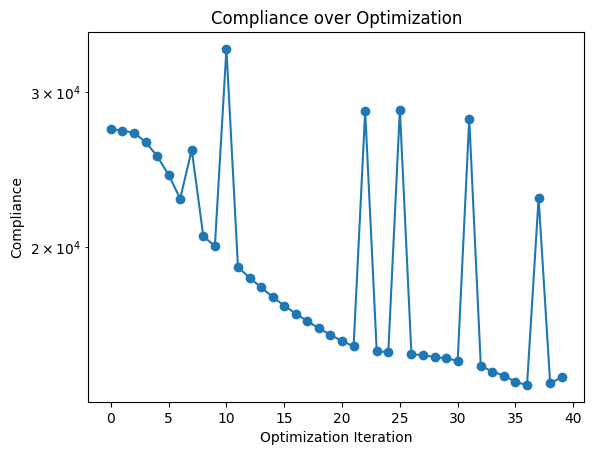

In [228]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [230]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

ims = []
for params in params_hist[:40]:
    sdf = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "grid_center": [0.0, 0.0, 0.0],
        },
    )["sdf"]

    rho = sdf_to_rho(sdf)

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [ ]:
# lets visualize the 3d meshes over the optimization
for i, params in enumerate(params_hist):
    design_out = design_tess.apply(
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "grid_center": [0.0, 0.0, 0.0],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        }
    )
    surface_mesh = design_out["mesh"]

    num_vertices = surface_mesh["n_points"]
    num_faces = surface_mesh["n_faces"]

    points = surface_mesh["points"][:num_vertices]
    faces = surface_mesh["faces"][:num_faces]

    mesh = {
        "points": points,
        "faces": faces,
    }

    plot_mesh(mesh, save_path=f"tmp_img/mesh_optim_{i:03d}.png")